# import

In [22]:
import json
import os
import pathlib
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

# Load topic json data files

In [2]:
topic_json_data_dir = pathlib.Path.cwd().parent / "topic_json_data"

all_news_list = []

for json_file in os.listdir(topic_json_data_dir):
    topic_num = json_file.split('.')[0][-4:]
    with open(os.path.join(topic_json_data_dir, json_file)) as f:
        topic_data = json.load(f)
        for data in topic_data['data']:
            news_data = {
                'topic': topic_num,
                'title': data['title'],
                'paragraphs': data['content'],
                'uid': data['uid'],
            }
            all_news_list.append(news_data)

print("Total news:", len(all_news_list))

Total news: 684


# Preview a news data

In [3]:
all_news_list[0]

{'topic': '4092',
 'title': '拜登簽撥款法案 外交部：友台條文質量均前所未有',
 'paragraphs': ['針對美國總統拜登（Joe Biden）簽署「2023財政年度綜合撥款法」，外交部今天表示感謝，強調其中友台條文的「質與量均為前所未有」，且主動為台美雙方多個領域的合作增加更多資源。',
  '外交部發布新聞稿指出，拜登在美東時間29日簽署「2023財政年度綜合撥款法」，完成法案的立法程序，並為撥款法支持台灣的各項措施及倡議注入財政資源。',
  '外交部表示，該法案除首度納入外國軍事融資（FMF）貸款選項外，並提高挹注全球合作暨訓練架構（GCTF）經費至400萬美元，且同意美國在台協會（AIT）經費可用於台灣學人計畫（Taiwan Fellowship Program）。',
  '撥款法另指定核撥500萬美元給予國務院及美國國際開發總署（USAID），加強與台灣等區域盟友及夥伴在太平洋島國的合作計畫，也同意自國際軍事教育暨訓練（IMET）計畫中，撥款協助台灣參與等。',
  '針對此次立法，外交部表示，感謝拜登政府及美國國會跨黨派友人，再次展現對台美關係的支持及對台海安全的重視。政府未來將依據國家整體政策，持續與美國國會及行政部門溝通討論，逐步推動各項友台條文的落實。',
  '外交部指出，台灣將持續在現有堅實友好的基礎上，與美國密切聯繫合作，以深化雙邊夥伴關係。'],
 'uid': 'b8c43106-af7a-11ed-afc0-acde48001122'}

In [4]:
# remove news with same title
title_count = {}
for news in all_news_list:
    if news['title'] not in title_count:
        title_count[news['title']] = 1
    else:
        title_count[news['title']] += 1

for news in all_news_list:
    if title_count[news['title']] > 1:
        all_news_list.remove(news)

print("Total news after remove not unique:", len(all_news_list))

Total news after remove not unique: 670


In [ ]:
# count each topic's news
topic_count = {}
for news in all_news_list:
    topic = news['topic']
    if topic not in topic_count:
        topic_count[topic] = 1
    else:
        topic_count[topic] += 1

topic_count

# paragraph count and length analysis

In [6]:
df = pd.DataFrame(columns=['topic_num', 'title', 'paragraph_count', 'title_len'] + [f'paragraph[{i}]_len' for i in range(10)])

for news in all_news_list:
    topic_num = news['topic']
    title = news['title']
    paragraphs = news['paragraphs']
    title_len = len(title)
    paragraph_count = len(paragraphs)
    paragraph_lens = [len(p) for p in paragraphs]
    if paragraph_count < 10:
        paragraph_lens += [0] * (10 - paragraph_count)
    else:
        paragraph_lens = paragraph_lens[:10]

    new_row = pd.DataFrame([[topic_num, title, paragraph_count, title_len] + paragraph_lens], columns=df.columns)
    df = pd.concat([df, new_row], ignore_index=True)

df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric)

/var/folders/q1/yjtyjl7n4631vjyys7_0q0k40000gn/T/ipykernel_80854/1534653062.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric)


In [7]:
df.iloc[:, 1:].describe()

,paragraph_count,title_len,paragraph[0]_len,paragraph[1]_len,paragraph[2]_len,paragraph[3]_len,paragraph[4]_len,paragraph[5]_len,paragraph[6]_len,paragraph[7]_len,paragraph[8]_len,paragraph[9]_len
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,7.659701,22.640299,85.104478,90.220896,87.301493,84.135821,77.185075,65.235821,51.652239,38.311940,25.338806,17.089552
std,4.405190,2.637635,28.394580,53.551832,32.263932,35.968319,40.573929,48.211956,50.644987,48.291835,42.612799,36.473645
min,1.000000,13.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,21.000000,77.000000,67.000000,66.000000,62.250000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,23.000000,81.500000,87.000000,89.000000,88.000000,82.000000,73.000000,54.500000,0.000000,0.000000,0.000000
75%,9.000000,24.000000,90.000000,110.000000,110.000000,111.000000,106.000000,102.000000,94.000000,83.750000,53.000000,0.000000
max,64.000000,34.000000,687.000000,944.000000,184.000000,173.000000,208.000000,194.000000,172.000000,157.000000,190.000000,175.000000


In [8]:
df.iloc[:, 1:].describe().loc['mean']

paragraph_count      7.659701
title_len           22.640299
paragraph[0]_len    85.104478
paragraph[1]_len    90.220896
paragraph[2]_len    87.301493
paragraph[3]_len    84.135821
paragraph[4]_len    77.185075
paragraph[5]_len    65.235821
paragraph[6]_len    51.652239
paragraph[7]_len    38.311940
paragraph[8]_len    25.338806
paragraph[9]_len    17.089552
Name: mean, dtype: float64

# Prepare input data

In [10]:
topic_num_list = [news['topic'] for news in all_news_list]
title_list = [news['title'] for news in all_news_list]
paragraph0_list = [news['paragraphs'][0] for news in all_news_list]
paragraph1_list = []

for news in all_news_list:
    if len(news['paragraphs']) > 1:
        paragraph1_list.append(news['paragraphs'][1])
    else:
        paragraph1_list.append('')

In [19]:
model_names = [
    'paraphrase-multilingual-MiniLM-L12-v2',
    'paraphrase-multilingual-mpnet-base-v2',
    'distiluse-base-multilingual-cased-v2',
    'distiluse-base-multilingual-cased-v1'
]

input_choices_text = {
    'title': title_list,
    'paragraph0': paragraph0_list,
    'paragraph1': paragraph1_list,
    'title&paragraph0': [t + p for t, p in zip(title_list, paragraph0_list)],
    'paragraph0&paragraph1': [p0 + p1 for p0, p1 in zip(paragraph0_list, paragraph1_list)],
    'title&paragraph0&paragraph1': [t + p0 + p1 for t, p0, p1 in zip(title_list, paragraph0_list, paragraph1_list)]
}

In [97]:
input_choices_embedding = {norm_or_not: {model_name: {} for model_name in model_names} for norm_or_not in ['norm', 'not_norm']}

for nor_or_not in ['norm', 'not_norm']:
    for model_name in model_names:
        for input_choice in input_choices_text.keys():
            print(f"model: {model_name}, input: {input_choice}")
            model = SentenceTransformer(
                model_name_or_path=model_name,
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                )
            input_choices_embedding[nor_or_not][model_name][input_choice] = model.encode(sentences=input_choices_text[input_choice], convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True if nor_or_not == 'norm' else False)

with open('input_and_model_choices_embedding_dict.pkl', 'wb') as f:
    pickle.dump(input_choices_embedding, f)

model: paraphrase-multilingual-MiniLM-L12-v2, input: title


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: title&paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: title&paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: title


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: title&paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: title&paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: title


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: title&paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: title&paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: title


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: title&paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: title&paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: title


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: title&paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-MiniLM-L12-v2, input: title&paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: title


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: title&paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: paraphrase-multilingual-mpnet-base-v2, input: title&paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: title


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: title&paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v2, input: title&paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: title


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: title&paragraph0


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

model: distiluse-base-multilingual-cased-v1, input: title&paragraph0&paragraph1


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

# input and model experiment

In [98]:
n_cluster_of_input = len(set(topic_num_list))
linkage_choice = ['ward', 'complete', 'average', 'single']
metric_choice = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
compute_distances_setting = True
compute_full_tree_setting = 'auto'

In [104]:
input_choices_embedding['norm']['paraphrase-multilingual-MiniLM-L12-v2']['title'] == input_choices_embedding['not_norm']['paraphrase-multilingual-MiniLM-L12-v2']['title'] 

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [100]:
df_model_input = pd.DataFrame(columns=['model_name', 'input_choice', 'norm_or_not', 'linkage', 'metric', 'homogeneity_score', 'completeness_score', 'v_measure_score'])

for norm_or_not in ['norm', 'not_norm']:
    for model_name in model_names:
        for input_embedding_key in input_choices_embedding[nor_or_not][model_name].keys():
            for linkage in linkage_choice:
                for metric in metric_choice:
                    if linkage == 'ward' and metric != 'euclidean':
                        continue
                    else:
                        cluster_model = AgglomerativeClustering(
                            n_clusters=n_cluster_of_input,
                            metric=metric,
                            linkage=linkage,
                            compute_distances=compute_distances_setting,
                            compute_full_tree=compute_full_tree_setting
                        )
                        input_embedding = input_choices_embedding[nor_or_not][model_name][input_embedding_key]
                        cluster_model.fit_predict(input_embedding)
                        cluser_result = cluster_model.labels_

                        homogeneity_score, completeness_score, v_measure_score = metrics.homogeneity_completeness_v_measure(topic_num_list, cluser_result)
                        print(f"model: {model_name}, input: {input_embedding_key}, 'norm_or_not': {nor_or_not}, linkage: {linkage}, metric: {metric}, homogeneity_score: {homogeneity_score}, completeness_score: {completeness_score}, v_measure_score: {v_measure_score}")
                        new_row = pd.DataFrame([[model_name, input_embedding_key, norm_or_not, linkage, metric, homogeneity_score, completeness_score, v_measure_score]], columns=df_model_input.columns)
                        df_model_input = pd.concat([df_model_input, new_row], ignore_index=True)

model: paraphrase-multilingual-MiniLM-L12-v2, input: title, 'norm_or_not': not_norm, linkage: ward, metric: euclidean, homogeneity_score: 0.6973306540075628, completeness_score: 0.6593791622871532, v_measure_score: 0.6778240961393274
model: paraphrase-multilingual-MiniLM-L12-v2, input: title, 'norm_or_not': not_norm, linkage: complete, metric: euclidean, homogeneity_score: 0.5275780362455025, completeness_score: 0.5916485923732765, v_measure_score: 0.5577794425726224
model: paraphrase-multilingual-MiniLM-L12-v2, input: title, 'norm_or_not': not_norm, linkage: complete, metric: l1, homogeneity_score: 0.4612931381211192, completeness_score: 0.5968150201220777, v_measure_score: 0.5203752969205541
model: paraphrase-multilingual-MiniLM-L12-v2, input: title, 'norm_or_not': not_norm, linkage: complete, metric: l2, homogeneity_score: 0.5275780362455025, completeness_score: 0.5916485923732765, v_measure_score: 0.5577794425726224
model: paraphrase-multilingual-MiniLM-L12-v2, input: title, 'norm_

In [123]:
df_model_input[df_model_input['norm_or_not'] == 'not_norm'].sort_values(by=['homogeneity_score', 'homogeneity_score', 'v_measure_score'], ascending=False)[:10].drop(columns=['norm_or_not'])

,model_name,input_choice,linkage,metric,homogeneity_score,completeness_score,v_measure_score
688,distiluse-base-multilingual-cased-v1,paragraph0,ward,euclidean,0.889506,0.839572,0.863818
640,distiluse-base-multilingual-cased-v2,paragraph0&paragraph1,ward,euclidean,0.884629,0.836867,0.860085
464,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0&paragraph1,ward,euclidean,0.878640,0.868480,0.873530
544,paraphrase-multilingual-mpnet-base-v2,paragraph0&paragraph1,ward,euclidean,0.878104,0.859611,0.868759
432,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0,ward,euclidean,0.875843,0.846850,0.861103
720,distiluse-base-multilingual-cased-v1,title&paragraph0,ward,euclidean,0.871332,0.816358,0.842949
656,distiluse-base-multilingual-cased-v2,title&paragraph0&paragraph1,ward,euclidean,0.870328,0.838200,0.853962
496,paraphrase-multilingual-mpnet-base-v2,paragraph0,ward,euclidean,0.853712,0.808544,0.830515
400,paraphrase-multilingual-MiniLM-L12-v2,paragraph0,ward,euclidean,0.849370,0.810700,0.829584
560,paraphrase-multilingual-mpnet-base-v2,title&paragraph0&paragraph1,ward,euclidean,0.842800,0.836909,0.839844


In [101]:
df_model_input.sort_values(by=['homogeneity_score', 'homogeneity_score', 'v_measure_score'], ascending=False)[:20]

,model_name,input_choice,norm_or_not,linkage,metric,homogeneity_score,completeness_score,v_measure_score
304,distiluse-base-multilingual-cased-v1,paragraph0,norm,ward,euclidean,0.889506,0.839572,0.863818
688,distiluse-base-multilingual-cased-v1,paragraph0,not_norm,ward,euclidean,0.889506,0.839572,0.863818
256,distiluse-base-multilingual-cased-v2,paragraph0&paragraph1,norm,ward,euclidean,0.884629,0.836867,0.860085
640,distiluse-base-multilingual-cased-v2,paragraph0&paragraph1,not_norm,ward,euclidean,0.884629,0.836867,0.860085
80,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0&paragraph1,norm,ward,euclidean,0.878640,0.868480,0.873530
464,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0&paragraph1,not_norm,ward,euclidean,0.878640,0.868480,0.873530
160,paraphrase-multilingual-mpnet-base-v2,paragraph0&paragraph1,norm,ward,euclidean,0.878104,0.859611,0.868759
544,paraphrase-multilingual-mpnet-base-v2,paragraph0&paragraph1,not_norm,ward,euclidean,0.878104,0.859611,0.868759
48,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0,norm,ward,euclidean,0.875843,0.846850,0.861103
432,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0,not_norm,ward,euclidean,0.875843,0.846850,0.861103


In [76]:
# df_model_input.sort_values(by=['homogeneity_score', 'homogeneity_score', 'v_measure_score'], ascending=False)[:10] # not_norm

,model_name,input_choice,linkage,metric,homogeneity_score,completeness_score,v_measure_score
304,distiluse-base-multilingual-cased-v1,paragraph0,ward,euclidean,0.889506,0.839572,0.863818
256,distiluse-base-multilingual-cased-v2,paragraph0&paragraph1,ward,euclidean,0.884629,0.836867,0.860085
80,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0&paragraph1,ward,euclidean,0.878640,0.868480,0.873530
160,paraphrase-multilingual-mpnet-base-v2,paragraph0&paragraph1,ward,euclidean,0.878104,0.859611,0.868759
48,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0,ward,euclidean,0.875843,0.846850,0.861103
336,distiluse-base-multilingual-cased-v1,title&paragraph0,ward,euclidean,0.871332,0.816358,0.842949
272,distiluse-base-multilingual-cased-v2,title&paragraph0&paragraph1,ward,euclidean,0.870328,0.838200,0.853962
112,paraphrase-multilingual-mpnet-base-v2,paragraph0,ward,euclidean,0.853712,0.808544,0.830515
16,paraphrase-multilingual-MiniLM-L12-v2,paragraph0,ward,euclidean,0.849370,0.810700,0.829584
176,paraphrase-multilingual-mpnet-base-v2,title&paragraph0&paragraph1,ward,euclidean,0.842800,0.836909,0.839844


In [66]:
#df_model_input.sort_values(by=['homogeneity_score', 'homogeneity_score', 'v_measure_score'], ascending=False)[:10]# cosin

,model_name,input_choice,linkage,homogeneity_score,completeness_score,v_measure_score
33,paraphrase-multilingual-mpnet-base-v2,title&paragraph0&paragraph1,complete,0.818628,0.795156,0.806721
57,distiluse-base-multilingual-cased-v1,paragraph0,complete,0.817404,0.839673,0.828389
30,paraphrase-multilingual-mpnet-base-v2,paragraph0&paragraph1,complete,0.796570,0.798271,0.797420
3,paraphrase-multilingual-MiniLM-L12-v2,paragraph0,complete,0.788829,0.795069,0.791937
15,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0&paragraph1,complete,0.778965,0.774336,0.776644
63,distiluse-base-multilingual-cased-v1,title&paragraph0,complete,0.778046,0.854570,0.814514
12,paraphrase-multilingual-MiniLM-L12-v2,paragraph0&paragraph1,complete,0.767421,0.764130,0.765772
69,distiluse-base-multilingual-cased-v1,title&paragraph0&paragraph1,complete,0.755734,0.770751,0.763168
66,distiluse-base-multilingual-cased-v1,paragraph0&paragraph1,complete,0.754197,0.800417,0.776620
70,distiluse-base-multilingual-cased-v1,title&paragraph0&paragraph1,average,0.752982,0.910031,0.824091


In [37]:
# df_model_input.sort_values(by=['homogeneity_score', 'homogeneity_score', 'v_measure_score'], ascending=False)[:10] old version

,model_name,input_choice,linkage,homogeneity_score,completeness_score,v_measure_score
16,paraphrase-multilingual-MiniLM-L12-v2,paragraph0&paragraph1,ward,0.889619,0.842819,0.865587
64,distiluse-base-multilingual-cased-v2,paragraph0&paragraph1,ward,0.883592,0.838561,0.860488
76,distiluse-base-multilingual-cased-v1,paragraph0,ward,0.877803,0.823013,0.849526
40,paraphrase-multilingual-mpnet-base-v2,paragraph0&paragraph1,ward,0.876809,0.853722,0.865112
84,distiluse-base-multilingual-cased-v1,title&paragraph0,ward,0.867753,0.809749,0.837748
28,paraphrase-multilingual-mpnet-base-v2,paragraph0,ward,0.864062,0.822988,0.843025
12,paraphrase-multilingual-MiniLM-L12-v2,title&paragraph0,ward,0.860418,0.827290,0.843529
68,distiluse-base-multilingual-cased-v2,title&paragraph0&paragraph1,ward,0.856153,0.820478,0.837936
92,distiluse-base-multilingual-cased-v1,title&paragraph0&paragraph1,ward,0.855854,0.820358,0.837730
44,paraphrase-multilingual-mpnet-base-v2,title&paragraph0&paragraph1,ward,0.852397,0.828500,0.840278


# plot data for cluster result

In [105]:
model_name, input_embedding_key, norm_or_not, linkage, metric = df_model_input.sort_values(by=['homogeneity_score', 'homogeneity_score', 'v_measure_score'], ascending=False).iloc[0][['model_name', 'input_choice', 'norm_or_not', 'linkage', 'metric']]

cluster_model = AgglomerativeClustering(
    n_clusters=n_cluster_of_input,
    metric=metric,
    linkage=linkage,
    compute_distances=compute_distances_setting,
    compute_full_tree=compute_full_tree_setting
)

input_embedding = input_choices_embedding[nor_or_not][model_name][input_embedding_key]
cluster_model.fit_predict(input_embedding)
cluser_result = cluster_model.labels_

homogeneity_score, completeness_score, v_measure_score = metrics.homogeneity_completeness_v_measure(topic_num_list, cluser_result)
print(f"model: {model_name}, input: {input_embedding_key}, linkage: {linkage}, homogeneity_score: {homogeneity_score}, completeness_score: {completeness_score}, v_measure_score: {v_measure_score}")

model: distiluse-base-multilingual-cased-v1, input: paragraph0, linkage: ward, homogeneity_score: 0.8895060376866682, completeness_score: 0.839571633216868, v_measure_score: 0.863817802269826


/var/folders/q1/yjtyjl7n4631vjyys7_0q0k40000gn/T/ipykernel_80854/3615549167.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted(set(cluser_result)))


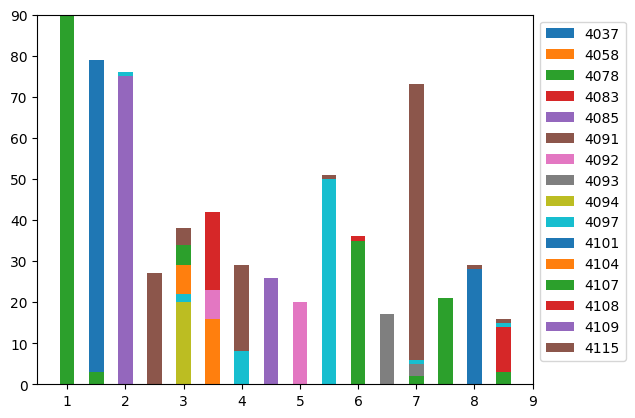

<Figure size 10000x10000 with 0 Axes>

In [116]:
count_dict = {cluster: {topic_num: 0 for topic_num in sorted(set(topic_num_list))} for cluster in sorted(set(cluser_result))}

for cluster, topic_num in zip(cluser_result, topic_num_list):
    count_dict[cluster][topic_num] += 1

clusters = sorted(set(cluser_result))

topic_num_counts = {topic_num: np.array([count_dict[cluster][topic_num] for cluster in clusters]) for topic_num in sorted(set(topic_num_list))}

width = 0.5  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
bottom = np.zeros(len(clusters))

for topic_num, count in topic_num_counts.items():
    p = ax.bar(clusters, count, width, label=topic_num, bottom=bottom)
    bottom += count
    # ax.bar_label(p, label_type='center')

# ax.set_title('Number of penguins by sex')
plt.figure(figsize=(100, 100))
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)
ax.set_xticklabels(sorted(set(cluser_result)))
plt.show()

# Descided distance_threshold

In [109]:
distance_threshold = cluster_model.distances_[-(n_cluster_of_input - 1)]

In [107]:
model_name, input_embedding_key, norm_or_not, linkage, metric = df_model_input.sort_values(by=['homogeneity_score', 'homogeneity_score', 'v_measure_score'], ascending=False).iloc[0][['model_name', 'input_choice', 'norm_or_not', 'linkage', 'metric']]
cluster_model2 = AgglomerativeClustering(
    # n_clusters=n_cluster_of_input,
    distance_threshold=distance_threshold,
    n_clusters=None,
    metric=metric,
    linkage=linkage,
    compute_distances=compute_distances_setting,
    compute_full_tree=compute_full_tree_setting
)
input_embedding = input_choices_embedding[nor_or_not][model_name][input_embedding_key]
cluster_model2.fit(input_embedding)
cluser_result = cluster_model2.labels_

homogeneity_score, completeness_score, v_measure_score = metrics.homogeneity_completeness_v_measure(topic_num_list, cluser_result)
print(f"model: {model_name}, input: {input_embedding_key}, linkage: {linkage}, homogeneity_score: {homogeneity_score}, completeness_score: {completeness_score}, v_measure_score: {v_measure_score}")

model: distiluse-base-multilingual-cased-v1, input: paragraph0, linkage: ward, homogeneity_score: 0.8895060376866682, completeness_score: 0.839571633216868, v_measure_score: 0.863817802269826


/var/folders/q1/yjtyjl7n4631vjyys7_0q0k40000gn/T/ipykernel_80854/3615549167.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted(set(cluser_result)))


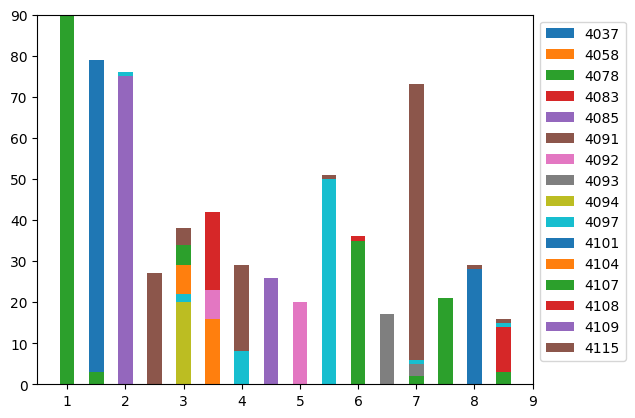

<Figure size 10000x10000 with 0 Axes>

In [117]:
count_dict = {cluster: {topic_num: 0 for topic_num in sorted(set(topic_num_list))} for cluster in sorted(set(cluser_result))}

for cluster, topic_num in zip(cluser_result, topic_num_list):
    count_dict[cluster][topic_num] += 1

clusters = sorted(set(cluser_result))

topic_num_counts = {topic_num: np.array([count_dict[cluster][topic_num] for cluster in clusters]) for topic_num in sorted(set(topic_num_list))}

width = 0.5  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
bottom = np.zeros(len(clusters))

for topic_num, count in topic_num_counts.items():
    p = ax.bar(clusters, count, width, label=topic_num, bottom=bottom)
    bottom += count
    # ax.bar_label(p, label_type='center')

# ax.set_title('Number of penguins by sex')
plt.figure(figsize=(100, 100))
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)
ax.set_xticklabels(sorted(set(cluser_result)))
plt.show()